In [1]:
import numpy as np

# Constants
L_v = 2.5e6        # Latent heat of vaporization (J/kg)
R_v = 461.5        # Specific gas constant for water vapor (J/(kg·K))
R_air = 287        # Specific gas constant for dry air (J/(kg·K))
T_0 = 273.15       # Reference temperature (K)
e_0 = 611.2        # Reference vapor pressure at T_0 (Pa)
P_atm = 101325     # Atmospheric pressure (Pa)
D = 2.5e-5         # Diffusion coefficient for water vapor in air (m²/s)
lambda_layer = 0.01  # Boundary layer thickness (meters)

# Chamber dimensions
L = 3              # Side length (meters)
H = 9              # Height (meters)

# Wall temperatures (C)
T_b = 20           # Bottom boundary temperature
T_t = 10           # Top boundary temperature
T_s = 20           # Temperature for two sidewalls
T_s_prime = 10     # Temperature for two other sidewalls

# Time period in hours
time_period_hours = 24


# function for calculating saturation vapor pressure
def saturation_vapor_pressure(T_celsius):
    T_kelvin = T_celsius + 273.15
    return e_0 * np.exp((L_v / R_v) * (1 / T_0 - 1 / T_kelvin))

# Saturation vapor pressures
e_b = saturation_vapor_pressure(T_b)
e_t = saturation_vapor_pressure(T_t)
e_s = saturation_vapor_pressure(T_s)
e_s_prime = saturation_vapor_pressure(T_s_prime)

# Mean temperature
T_mean = (T_b + T_t + 2 * (H / L) * T_s + 2 * (H / L) * T_s_prime) / (2 + 4 * (H / L))
T_mean_K = T_mean + 273.15

# Mean vapor pressure
e_mean = (e_b + e_t + 2 * (H / L) * e_s + 2 * (H / L) * e_s_prime) / (2 + 4 * (H / L))

# Air density
rho_a = P_atm / (R_air * T_mean_K)

# Supersaturation
e_s_mean = saturation_vapor_pressure(T_mean)
supersaturation = (e_mean / e_s_mean) - 1

# Wall areas
A_b = L * L
A_t = L * L
A_s = H * L

# Compute q_v 
numerator = (
     e_b / (rho_a * R_v * (T_b + 273.15)) * A_b
    +  e_t / (rho_a * R_v * (T_t + 273.15)) * A_t
    + 2 *  e_s / (rho_a * R_v * (T_s + 273.15)) * A_s
    + 2 *  e_s_prime / (rho_a * R_v * (T_s_prime + 273.15)) * A_s
)

denominator = (
     A_b + A_t + 4 * A_s
)

q_v = numerator / denominator

# Function to calculate flux and mass flow rate
def calculate_flux_and_mass_flow(q_v, e_sat, T_wall, A):
    T_wall_K = T_wall + 273.15
    qv_sat = e_sat / (rho_a * R_v * T_wall_K)
    J = (rho_a * D / lambda_layer) * (qv_sat - q_v)  # Flux (kg/m^2*s)
    mdot = J * A  
    return J, mdot, qv_sat

# Calculate fluxes and mass flow rates for each wall
J_b, mdot_b, qv_sat_b = calculate_flux_and_mass_flow(q_v, e_b, T_b, A_b)
J_t, mdot_t, qv_sat_t = calculate_flux_and_mass_flow(q_v, e_t, T_t, A_t)

# Two Side Walls at T_s
J_s, mdot_s, qv_sat_s = calculate_flux_and_mass_flow(q_v, e_s, T_s, A_s)
mdot_s_total = 2 * mdot_s

# Two Side Walls at T_s_prime
J_s_prime, mdot_s_prime, qv_sat_s_prime = calculate_flux_and_mass_flow(q_v, e_s_prime, T_s_prime, A_s)
mdot_s_prime_total = 2 * mdot_s_prime

# Net mass flow rate
Mdot_net = mdot_b + mdot_t + mdot_s_total + mdot_s_prime_total

# Calculate evaporated mass flow rate
net_evaporation_rate = mdot_b + mdot_s_total + mdot_s_prime_total  # Evaporation contributions from bottom and side walls

def calculate_water_volume(evaporation_rate, time_hours):
    time_seconds = time_hours * 3600  
    water_density = 1000  # Density of water in kg/m^3
    total_mass = evaporation_rate * time_seconds  # Total mass of evaporated water in kg
    volume_liters = total_mass / water_density * 1000  # Convert m^3 to liters

    return volume_liters, time_seconds
    
# Calculate water volume
water_volume_liters, time_period_seconds = calculate_water_volume(net_evaporation_rate, time_period_hours)

# Conversion from liters to gallons
liter_to_gallon = 0.264172  # Conversion factor
water_volume_gallons = water_volume_liters * liter_to_gallon


# Output results
print(f"Mean vapor pressure: {e_mean:.2f} Pa")
print(f"Mean temperature: {T_mean:.2f} °C")
print(f"Mixing ratio (q_v): {q_v:.8f} kg/kg")
print(f"Saturation vapor pressure at mean temperature: {e_s_mean:.2f} Pa")
print(f"Supersaturation: {supersaturation:.4f}")
print(f"Bottom Wall: J = {J_b:.8f} kg/m²/s, mdot = {mdot_b:.8f} kg/s")
print(f"Top Wall: J = {J_t:.8f} kg/m²/s, mdot = {mdot_t:.8f} kg/s")
print(f"Two Side Walls (T_s): J = {J_s:.8f} kg/m²/s, mdot_total = {mdot_s_total:.8f} kg/s")
print(f"Two Side Walls (T_s_prime): J = {J_s_prime:.8f} kg/m²/s, mdot_total = {mdot_s_prime_total:.8f} kg/s")
print(f"Net mass flow rate: {Mdot_net:.8f} kg/s")
print(f"Water volume sourced over {time_period_hours} hours: {water_volume_liters:.2f} liters ({water_volume_gallons:.2f} gallons)")

mdot_single = mdot_s_total / 2
print(f"Mass flow rate for one evaporating side wall at T_s: {mdot_single:.8f} kg/s")


Mean vapor pressure: 1798.06 Pa
Mean temperature: 15.00 °C
Mixing ratio (q_v): 0.01097859 kg/kg
Saturation vapor pressure at mean temperature: 1716.09 Pa
Supersaturation: 0.0478
Bottom Wall: J = 0.00001007 kg/m²/s, mdot = 0.00009064 kg/s
Top Wall: J = -0.00001007 kg/m²/s, mdot = -0.00009064 kg/s
Two Side Walls (T_s): J = 0.00001007 kg/m²/s, mdot_total = 0.00054385 kg/s
Two Side Walls (T_s_prime): J = -0.00001007 kg/m²/s, mdot_total = -0.00054385 kg/s
Net mass flow rate: 0.00000000 kg/s
Water volume sourced over 24 hours: 7.83 liters (2.07 gallons)
Mass flow rate for one evaporating side wall at T_s: 0.00027192 kg/s


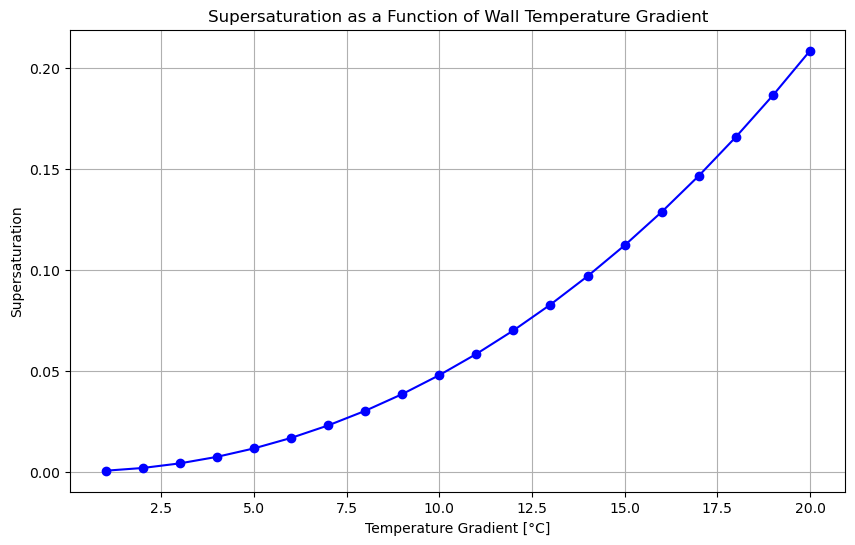

In [2]:
# Supersaturation vs Wall Temperature Gradient Plot

import matplotlib.pyplot as plt
import numpy as np

# Temperature gradient range (5 C to 25 C) with discrete integers
temperature_gradients = np.arange(1, 21, 1)  # Every degree from 5 C to 25 C

# Function to calculate supersaturation for a given gradient
def calculate_supersaturation_for_gradient(delta_T):
    T_b = 20  # Bottom wall temperature 
    T_t = T_b - delta_T  # Top wall temperature based on gradient
    
    T_s = T_b  # Sidewalls 1 temperature
    T_s_prime = T_t  # Sidewalls 2 temperature
    
    e_b = saturation_vapor_pressure(T_b)
    e_t = saturation_vapor_pressure(T_t)
    e_s = saturation_vapor_pressure(T_s)
    e_s_prime = saturation_vapor_pressure(T_s_prime)
    
    T_mean = (T_b + T_t + 2 * (H / L) * T_s + 2 * (H / L) * T_s_prime) / (2 + 4 * (H / L))
    T_mean_K = T_mean + 273.15
    
    e_mean = (e_b + e_t + 2 * (H / L) * e_s + 2 * (H / L) * e_s_prime) / (2 + 4 * (H / L))
    e_s_mean = saturation_vapor_pressure(T_mean)
    
    supersaturation = (e_mean / e_s_mean) - 1
    return supersaturation

# Calculate supersaturation for each gradient
supersaturation_values = [calculate_supersaturation_for_gradient(delta_T) for delta_T in temperature_gradients]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(temperature_gradients, supersaturation_values, marker='o', linestyle='-', color='b')
plt.xlabel('Temperature Gradient [°C]')
plt.ylabel('Supersaturation')
plt.title('Supersaturation as a Function of Wall Temperature Gradient')
plt.grid(True)
plt.show()


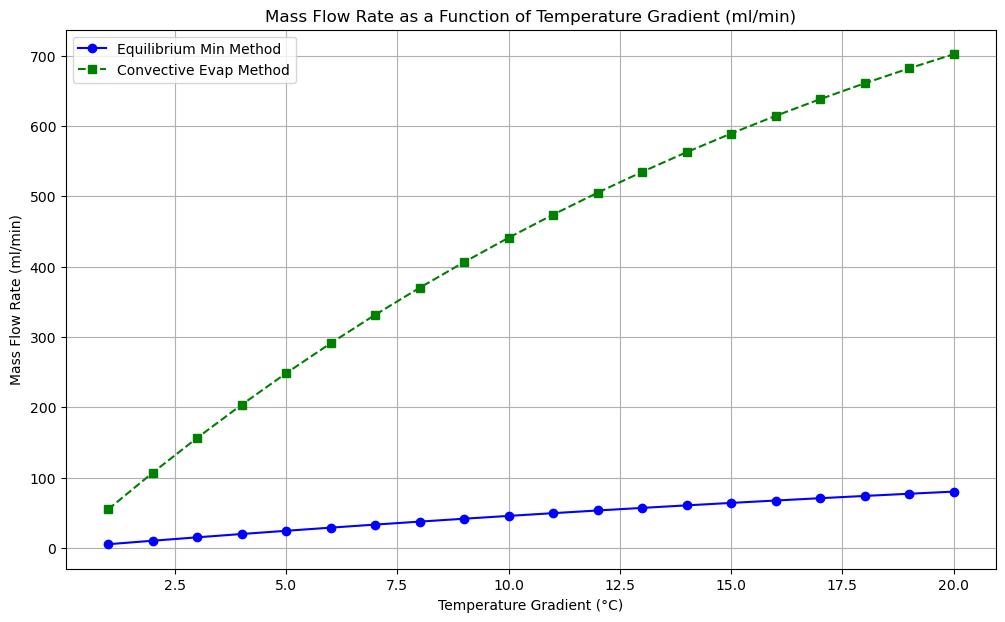

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 0.01  # Mass transfer coefficient (m/s), assumed value
L = 3      # Side length (m)
H = 9      # Height (m)
R_v = 461.5  # Specific gas constant for water vapor (J/(kg·K))
rho_a = 1.225  # Air density (kg/m^3) at standard conditions
T_0 = 273.15  # Reference temperature (K)
e_0 = 611.2   # Reference vapor pressure at T_0 (Pa)
D = 2.5e-5  # Diffusion coefficient (m^2/s)
lambda_layer = 0.01  # Boundary layer thickness (m)

# Surface area of the side walls (m^2)
A_s = 2 * H * L

# Temperature gradient range
temperature_gradients = np.arange(1, 21, 1)

# Saturation vapor pressure function
def saturation_vapor_pressure(T_celsius):
    T_kelvin = T_celsius + 273.15
    return e_0 * np.exp((2.5e6 / R_v) * (1 / T_0 - 1 / T_kelvin))

# Method 1: Flux-Based Method
def calculate_mass_flow_with_flux(delta_T):
    T_b = 20  # Bottom wall temperature (C)
    T_t = T_b - delta_T  # Top wall temperature (C)

    T_s = T_b  # Side wall temperature (C)
    T_s_prime = T_t  # Opposite side wall temperature (C)

    T_wall_K = T_s + 273.15
    T_mean = (T_b + T_t + 2 * (H / L) * T_s + 2 * (H / L) * T_s_prime) / (2 + 4 * (H / L))
    T_mean_K = T_mean + 273.15

    # Vapor pressures
    e_wall = saturation_vapor_pressure(T_s)
    e_mean = saturation_vapor_pressure(T_mean)

    # Flux-based mass flow rate
    J = (rho_a * D / lambda_layer) * ((e_wall / (R_v * T_wall_K)) - (e_mean / (R_v * T_mean_K)))
    mdot = J * A_s  # Mass flow rate (kg/s)

    return mdot

# Method 2: Vapor Pressure Difference Method
def calculate_mass_flow_with_vapor_pressure(h, T_wall, T_mean):
    T_wall_K = T_wall + 273.15
    T_mean_K = T_mean + 273.15

    e_wall = saturation_vapor_pressure(T_wall)
    e_mean = saturation_vapor_pressure(T_mean)

    # Vapor pressure difference mass flow rate
    mdot = h * (e_wall / (R_v * T_wall_K) - e_mean / (R_v * T_mean_K)) * A_s
    return mdot

# Calculate mass flow rates for each method
mass_flow_rates_method1 = []
mass_flow_rates_method2 = []

for delta_T in temperature_gradients:
    # Method 1: Flux-Based
    mdot_method1 = calculate_mass_flow_with_flux(delta_T)
    mass_flow_rates_method1.append(mdot_method1)

    # Method 2: Vapor Pressure Difference
    T_wall = 30  # Wall temperature (C)
    T_mean = T_wall - delta_T  # Mean air temperature (C)
    mdot_method2 = calculate_mass_flow_with_vapor_pressure(h, T_wall, T_mean)
    mass_flow_rates_method2.append(mdot_method2)

# Convert mass flow rates from kg/s to ml/min
mass_flow_rates_method1_ml_min = [mdot * 60 * 1000 for mdot in mass_flow_rates_method1]
mass_flow_rates_method2_ml_min = [mdot * 60 * 1000 for mdot in mass_flow_rates_method2]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(temperature_gradients, mass_flow_rates_method1_ml_min, marker='o', linestyle='-', color='b', label='Equilibrium Min Method')
plt.plot(temperature_gradients, mass_flow_rates_method2_ml_min, marker='s', linestyle='--', color='g', label='Convective Evap Method')
plt.xlabel('Temperature Gradient (°C)')
plt.ylabel('Mass Flow Rate (ml/min)')
plt.title('Mass Flow Rate as a Function of Temperature Gradient (ml/min)')
plt.legend()
plt.grid(True)
plt.show()


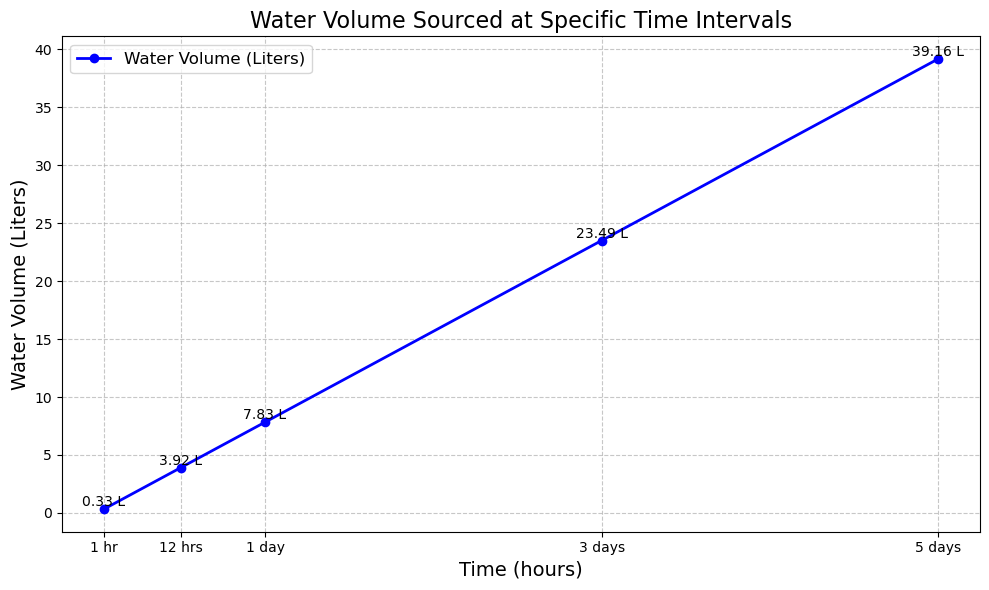

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Time intervals of interest in hours
time_intervals = [1, 12, 24, 3 * 24, 5 * 24]  # 1 hour, 12 hours, 1 day, 3 days, 5 days

# Calculate water volume for each interval
water_volumes = [
    calculate_water_volume(net_evaporation_rate, t)[0] for t in time_intervals
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_intervals, water_volumes, marker='o', color="blue", linewidth=2, label="Water Volume (Liters)")

# Add labels on the graph for actual numbers
for t, volume in zip(time_intervals, water_volumes):
    plt.text(t, volume, f"{volume:.2f} L", fontsize=10, ha='center', va='bottom')

# Labels and title
plt.title("Water Volume Sourced at Specific Time Intervals", fontsize=16)
plt.xlabel("Time (hours)", fontsize=14)
plt.ylabel("Water Volume (Liters)", fontsize=14)
plt.xticks(time_intervals, ['1 hr', '12 hrs', '1 day', '3 days', '5 days'])  # Custom x-ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show plot
plt.show()
